In [1]:
#from generator import UNETGenerator
from keras.layers import Activation, Input, Dropout, merge,concatenate
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

Using TensorFlow backend.


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# ---------------------------------------------
# HYPER PARAMS
# ---------------------------------------------
# width, height of images to work with. Assumes images are square
im_width = im_height = 256

# inpu/oputputt channels in image
input_channels = 3
output_channels = 3

# image dims
input_img_dim = (im_width, im_height,input_channels)
output_img_dim = (im_width, im_height,output_channels)

In [4]:
def UNETGenerator(input_img_dim, num_output_channels):
    """
    Creates the generator according to the specs in the paper below.
    It's basically a skip layer AutoEncoder
    Generator does the following:
    1. Takes in an image
    2. Generates an image from this image
    Differs from a standard GAN because the image isn't random.
    This model tries to learn a mapping from a suboptimal image to an optimal image.
    [https://arxiv.org/pdf/1611.07004v1.pdf][5. Appendix]
    :param input_img_dim: (channel, height, width)
    :param output_img_dim: (channel, height, width)
    :return:
    """
    # -------------------------------
    # ENCODER
    # C64-C128-C256-C512-C512-C512-C512-C512
    # 1 layer block = Conv - BN - LeakyRelu
    # -------------------------------
    stride = 2
    merge_mode = 'concat'

    # batch norm mode
    bn_mode = 2

    # batch norm merge axis
    bn_axis = 3
    bn_axis_1 = 3

    input_layer = Input(shape=input_img_dim, name="unet_input")

    # 1 encoder C64
    # skip batchnorm on this layer on purpose (from paper)
    en_1 = Convolution2D(nb_filter=64, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(input_layer)
    #en_1 = Conv2D(filters=64,kernel_size=4,padding="same",strides=2)(input_layer)
    en_1 = LeakyReLU(alpha=0.2)(en_1)

#     # 2 encoder C128
    en_2 = Convolution2D(nb_filter=64, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(en_1)
    #en_2 = Conv2D(filters=64,kernel_size=4,padding="same",strides=2)(en_1)
    en_2 = BatchNormalization(name='gen_en_bn_2', axis=bn_axis)(en_2)
    en_2 = LeakyReLU(alpha=0.2)(en_2)

    # 3 encoder C256
    en_3 = Convolution2D(nb_filter=256, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(en_2)
    en_3 = BatchNormalization(name='gen_en_bn_3', axis=bn_axis)(en_3)
    en_3 = LeakyReLU(alpha=0.2)(en_3)

    # 4 encoder C512
    en_4 = Convolution2D(nb_filter=512, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(en_3)
    en_4 = BatchNormalization(name='gen_en_bn_4', axis=bn_axis)(en_4)
    en_4 = LeakyReLU(alpha=0.2)(en_4)

    # 5 encoder C512
    en_5 = Convolution2D(nb_filter=512, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(en_4)
    en_5 = BatchNormalization(name='gen_en_bn_5', axis=bn_axis)(en_5)
    en_5 = LeakyReLU(alpha=0.2)(en_5)

    # 6 encoder C512
    en_6 = Convolution2D(nb_filter=512, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(en_5)
    en_6 = BatchNormalization(name='gen_en_bn_6', axis=bn_axis)(en_6)
    en_6 = LeakyReLU(alpha=0.2)(en_6)

    # 7 encoder C512
    en_7 = Convolution2D(nb_filter=512, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(en_6)
    en_7 = BatchNormalization(name='gen_en_bn_7', axis=bn_axis)(en_7)
    en_7 = LeakyReLU(alpha=0.2)(en_7)

    # 8 encoder C512
    en_8 = Convolution2D(nb_filter=512, nb_row=4, nb_col=4, border_mode='same', subsample=(stride, stride))(en_7)
    en_8 = BatchNormalization(name='gen_en_bn_8', axis=bn_axis)(en_8)
    en_8 = LeakyReLU(alpha=0.2)(en_8)
    
#    unet_generator = Model(input=[input_layer], output=[en_8], name='unet_generator')


    # -------------------------------
    # DECODER
    # CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    # 1 layer block = Conv - Upsample - BN - DO - Relu
    # also adds skip connections (merge). Takes input from previous layer matching encoder layer
    # -------------------------------
    # 1 decoder CD512 (decodes en_8)
    de_1 = UpSampling2D(size=(2, 2))(en_8)
    de_1 = Convolution2D(nb_filter=512, nb_row=4, nb_col=4, border_mode='same')(de_1)
    de_1 = BatchNormalization(name='gen_de_bn_1', axis=bn_axis)(de_1)
    de_1 = Dropout(p=0.5)(de_1)
    #de_1 = merge([de_1, en_7], mode=merge_mode, concat_axis=1)
    de_1 = concatenate([de_1, en_7],axis = bn_axis_1)
    de_1 = Activation('relu')(de_1)

    # 2 decoder CD1024 (decodes en_7)
    de_2 = UpSampling2D(size=(2, 2))(de_1)
    de_2 = Convolution2D(nb_filter=1024, nb_row=4, nb_col=4, border_mode='same')(de_2)
    de_2 = BatchNormalization(name='gen_de_bn_2', axis=bn_axis)(de_2)
    de_2 = Dropout(p=0.5)(de_2)
    #de_2 = merge([de_2, en_6], mode=merge_mode, concat_axis=1)
    de_2 = concatenate([de_2, en_6],axis = bn_axis_1)
    de_2 = Activation('relu')(de_2)

    # 3 decoder CD1024 (decodes en_6)
    de_3 = UpSampling2D(size=(2, 2))(de_2)
    de_3 = Convolution2D(nb_filter=1024, nb_row=4, nb_col=4, border_mode='same')(de_3)
    de_3 = BatchNormalization(name='gen_de_bn_3', axis=bn_axis)(de_3)
    de_3 = Dropout(p=0.5)(de_3)
    #de_3 = merge([de_3, en_5], mode=merge_mode, concat_axis=1)
    de_3 = concatenate([de_3, en_5],axis = bn_axis_1)
    de_3 = Activation('relu')(de_3)

    # 4 decoder CD1024 (decodes en_5)
    de_4 = UpSampling2D(size=(2, 2))(de_3)
    de_4 = Convolution2D(nb_filter=1024, nb_row=4, nb_col=4, border_mode='same')(de_4)
    de_4 = BatchNormalization(name='gen_de_bn_4', axis=bn_axis)(de_4)
    de_4 = Dropout(p=0.5)(de_4)
    #de_4 = merge([de_4, en_4], mode=merge_mode, concat_axis=1)
    de_4 = concatenate([de_4, en_4],axis = bn_axis_1)
    de_4 = Activation('relu')(de_4)

    # 5 decoder CD1024 (decodes en_4)
    de_5 = UpSampling2D(size=(2, 2))(de_4)
    de_5 = Convolution2D(nb_filter=1024, nb_row=4, nb_col=4, border_mode='same')(de_5)
    de_5 = BatchNormalization(name='gen_de_bn_5', axis=bn_axis)(de_5)
    de_5 = Dropout(p=0.5)(de_5)
    #de_5 = merge([de_5, en_3], mode=merge_mode, concat_axis=1)
    de_5 = concatenate([de_5, en_3],axis = bn_axis_1)
    de_5 = Activation('relu')(de_5)

    # 6 decoder C512 (decodes en_3)
    de_6 = UpSampling2D(size=(2, 2))(de_5)
    de_6 = Convolution2D(nb_filter=512, nb_row=4, nb_col=4, border_mode='same')(de_6)
    de_6 = BatchNormalization(name='gen_de_bn_6', axis=bn_axis)(de_6)
    de_6 = Dropout(p=0.5)(de_6)
    #de_6 = merge([de_6, en_2], mode=merge_mode, concat_axis=1)
    de_6 = concatenate([de_6, en_2],axis = bn_axis_1)
    de_6 = Activation('relu')(de_6)

    # 7 decoder CD256 (decodes en_2)
    de_7 = UpSampling2D(size=(2, 2))(de_6)
    de_7 = Convolution2D(nb_filter=256, nb_row=4, nb_col=4, border_mode='same')(de_7)
    de_7 = BatchNormalization(name='gen_de_bn_7', axis=bn_axis)(de_7)
    de_7 = Dropout(p=0.5)(de_7)
    #de_7 = merge([de_7, en_1], mode=merge_mode, concat_axis=1)
    de_7 = concatenate([de_7, en_1],axis = bn_axis_1)
    de_7 = Activation('relu')(de_7)

    # After the last layer in the decoder, a convolution is applied
    # to map to the number of output channels (3 in general,
    # except in colorization, where it is 2), followed by a Tanh
    # function.
    de_8 = UpSampling2D(size=(2, 2))(de_7)
    de_8 = Convolution2D(nb_filter=num_output_channels, nb_row=4, nb_col=4, border_mode='same')(de_8)
    # 最后一层在部分得layer得左上部分数值过大，导致拟合效果不好，加一个batchnorm试试
    #de_8 = BatchNormalization(name='gen_de_bn_8', axis=bn_axis)(de_8)
    de_8 = Activation('tanh')(de_8)

    unet_generator = Model(input=[input_layer], output=[de_8], name='unet_generator')
    return unet_generator


In [5]:
generator_nn = UNETGenerator(input_img_dim=input_img_dim, num_output_channels=output_channels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(4, 4), filters=64, strides=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(4, 4), filters=64, strides=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(4, 4), filters=256, strides=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(4, 4), filters=512, strides=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(4, 4), filters=512, strides=(2, 2), padding="same")`
/usr/local/l

In [6]:
generator_nn.summary()

Model: "unet_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unet_input (InputLayer)         (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3136        unet_input[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   65600       leaky_re_lu_1[0][0]              
_____________________________________________________________________________________

In [7]:
generator_nn.load_weights("b_a_model_79.h5")

In [12]:
import cv2
my_pic = cv2.imread("./facades/test/1.jpg")
my_pic=  my_pic[:,256:,:]
my_pic = my_pic.reshape(1,256,256,3)
my_pic = (my_pic - 127.5) / 127.5

In [9]:
import matplotlib.pyplot as plt
def plot_weight(model,layer,my_pic):
    print(generator_nn.layers[layer].name)
    intermediate_layer_model = Model(inputs=model.input
                                     ,outputs=model.layers[layer].output)
    fake_pic = intermediate_layer_model.predict(my_pic)
    fake_pic = fake_pic * 127.5 + 127.5
    fake_pic = fake_pic.astype(np.uint8)
    print(fake_pic.shape)
    num = fake_pic.shape[-1]
    plt.figure()
    for i in range(1,min(25,num+1)):
        #print(i)
        plt.subplot(5,5,i)
        plt.imshow(fake_pic[0][...,i-1])

    #     plt.xticks([])
    #     plt.yticks([])
    plt.show()

In [10]:
def get_weight(model,layer,my_pic):
    print(generator_nn.layers[layer].name,layer)
    intermediate_layer_model = Model(inputs=model.input
                                     ,outputs=model.layers[layer].output)
    fake_pic = intermediate_layer_model.predict(my_pic)
    #print(fake_pic.shape)
    print(fake_pic[0,:10,:10,:].mean(0).mean(0)[:30])
    print(fake_pic[0,-10:,-10:,:].mean(0).mean(0)[:30])
    #print(fake_pic[0].mean(2))
    print("*"*20)
    return fake_pic

In [20]:
fake_pic = get_weight(generator_nn,-38,my_pic)

conv2d_10 -38
[-27.395023   -8.375882   -4.2234936   3.0635133 -26.043005  -20.09834
  41.233376   20.679707  -22.083996    9.669666   10.585564   13.40094
  47.386337    1.410625  -38.24436   -19.987568   15.896393   14.543865
 -12.6336     -8.557225  -18.90237    17.677925   36.277054   -4.37844
 -25.597271   -8.3947315  -8.495668    7.7755136   2.334445   -2.4003313]
[-27.395023   -8.375882   -4.2234936   3.0635133 -26.043005  -20.09834
  41.233376   20.679707  -22.083996    9.669666   10.585564   13.40094
  47.386337    1.410625  -38.24436   -19.987568   15.896393   14.543865
 -12.6336     -8.557225  -18.90237    17.677925   36.277054   -4.37844
 -25.597271   -8.3947315  -8.495668    7.7755136   2.334445   -2.4003313]
********************


In [29]:
fake_pic[0].mean(2)

array([[ 6.0437818 ,  2.4452713 , -0.9157131 ,  0.14294964],
       [ 0.35122025, -1.0745333 , -2.1857808 , -0.7371348 ],
       [-2.1479712 , -2.6387873 , -2.2193882 , -1.2726669 ],
       [-1.1424829 , -0.39181572,  0.55167246,  0.76557374]],
      dtype=float32)

In [22]:
for i in range(1,17):
    print("conv2d_%d" % i)
    tmp = generator_nn.get_layer("conv2d_%d" % i).get_weights()
    #print(tmp[0].mean(2).mean(2))

conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_5
conv2d_6
conv2d_7
conv2d_8
conv2d_9
conv2d_10
conv2d_11
conv2d_12
conv2d_13
conv2d_14
conv2d_15
conv2d_16


In [40]:
tmp2 = generator_nn.layers[-57].get_weights()
tmp2[0].mean(2).mean(2)

array([[-7.45095778e-04, -3.06877599e-04, -3.22695938e-04,
        -8.29408527e-04],
       [-3.33071046e-04, -8.39664062e-05, -1.14248051e-05,
        -4.12662223e-04],
       [-3.73197254e-04,  1.09584747e-04,  1.06982516e-04,
        -3.70044814e-04],
       [-3.11869604e-04, -1.38200448e-05, -2.52225509e-05,
        -2.88208015e-04]], dtype=float32)

In [23]:
for i in range(-1,0-len(generator_nn.layers),-1):
    get_weight(generator_nn,i,my_pic)

activation_8 -1
[0.48181137 0.3583783  0.21925354]
[-0.49508873 -0.50407684 -0.4931497 ]
********************
conv2d_16 -2
[20.419964  17.262583  14.2120075]
[-0.5524303  -0.55933136 -0.5449551 ]
********************
up_sampling2d_8 -3
[23.19077  25.01278   0.       27.76768  25.7851   25.94447  24.979021
 23.506054 24.834728 25.137539 25.06698  21.780315 26.194202 27.059978
 22.861256 29.039928  0.       25.371857 25.56332  22.922295 21.55914
 27.068783 26.465887 28.043362 27.35559  26.00063  23.977713 26.529312
 17.452938 26.697147]
[2.6706789e-02 4.5091333e-04 3.3898219e-02 5.9858261e-04 2.2904193e-03
 0.0000000e+00 1.1007278e-02 1.3144620e-01 1.0118767e-01 0.0000000e+00
 6.1578327e-03 5.7847742e-03 1.2122381e-03 7.8010018e-04 3.0542720e-02
 8.8869929e-05 4.5385566e-01 7.4365974e-04 2.0641688e-02 1.7746429e-01
 0.0000000e+00 0.0000000e+00 1.7917670e-02 0.0000000e+00 9.9047367e-04
 8.2717566e-03 0.0000000e+00 0.0000000e+00 4.6531558e-03 0.0000000e+00]
********************
activation_

[  -4.7298074   26.462214     3.2465808   54.24227     -6.076188
   -9.662418     4.267533    28.802753     9.341864    -1.786856
   16.588644    22.068546    73.695816   100.955795    50.37923
   26.381495     3.6198628   45.784813    35.335423    41.684067
   24.463123    -2.245617    74.16433      7.347758     9.878859
   44.396107  -247.67966     12.906906    75.32311    -34.13326  ]
[-0.35692146  0.5104441  -0.6728013  -0.38905174 -2.2427676   0.51715314
 -0.06826387 -1.5845124   0.5578802  -0.44384012 -0.34809005  0.6117924
 -0.10550003 -0.29764387  0.09205534  0.37397686 -0.12249485 -1.0599356
 -0.29545546 -1.3056736  -1.7193235  -1.2979772  -0.9812352   0.38014385
 -0.16644959  0.10545664 -1.1565487  -0.1311106  -0.27529576 -0.8177477 ]
********************
up_sampling2d_6 -15
[19.430483   12.663328    8.909983    8.069286   22.219522    0.
 22.60738    16.955654   16.02702    13.295573   11.229861    0.22144409
  0.         10.467752   22.088058    7.242072    9.009348   24.73

[-19.597904  -32.78319    15.964124    4.923355    1.8494692  15.859428
  16.593723   29.124226    4.3310823   9.901624  -11.251159   31.932407
  22.937243    9.544821  -12.639275  -27.25326   -30.636866   20.214695
 -18.880297    7.107039   10.339144    3.3754246  13.000078    3.265493
 -35.18119     9.957041  -11.313472   20.133987  -30.543362    7.332634 ]
[-10.490768  -13.512917    4.707637   -2.3526947   2.923074    5.0871687
   3.9430814  11.063677   -2.3600547   2.1798644  -7.085803   10.828765
   4.73443     1.2340997  -9.010572  -10.460713  -13.05495    10.03544
  -9.190571    2.8809378  -0.8071264  -2.5770006   4.702077   -2.4585445
 -17.500683    2.1511266  -6.79988     7.4693613 -11.653444   -0.67404  ]
********************
conv2d_12 -26
[ -56.77819   -137.2225      39.01835     15.897191     3.643483
   51.496174    54.974964   101.02507     12.613804    24.05926
  -30.693567   110.18764     82.592476    33.48046    -29.186178
 -101.454765   -91.451065    78.1082     -59.3

[-29.352524   -7.9647913  -2.2253056   2.0917258 -23.961037  -27.30553
  44.233192   27.607635  -15.00426    10.282043   11.159478   10.60819
  58.586155    1.2399728 -42.68489   -21.24049    15.549847   16.482857
 -11.437796  -10.051247  -19.543488   14.710865   38.329742   -4.863669
 -20.752598   -7.3904495  -8.380499    7.0299215   2.296134   -2.7665958]
[-29.352524   -7.9647913  -2.2253056   2.0917258 -23.961037  -27.30553
  44.233192   27.607635  -15.00426    10.282043   11.159478   10.60819
  58.586155    1.2399728 -42.68489   -21.24049    15.549847   16.482857
 -11.437796  -10.051247  -19.543488   14.710865   38.329742   -4.863669
 -20.752598   -7.3904495  -8.380499    7.0299215   2.296134   -2.7665958]
********************
gen_de_bn_2 -37
[-29.352524   -7.9647913  -2.2253056   2.0917258 -23.961037  -27.30553
  44.233192   27.607635  -15.00426    10.282043   11.159478   10.60819
  58.586155    1.2399728 -42.68489   -21.24049    15.549847   16.482857
 -11.437796  -10.051247  -19.

[ 28.355278     2.6633825   16.16796     -4.0879836    4.258186
 -17.2131      -1.2670488    6.3461175   -1.2499523   -3.8933425
 -13.068478     0.41431332  -3.0972204    6.466732    -6.1775846
   8.420592    -9.55291     -1.0952777   -6.322867    17.3642
  -6.2431192   -4.6749783   -1.1414945   -6.3410506    0.460104
   3.6777267    6.7524543    7.702277     3.3677998   -9.571353  ]
[ 28.355278     2.6633825   16.16796     -4.0879836    4.258186
 -17.2131      -1.2670488    6.3461175   -1.2499523   -3.8933425
 -13.068478     0.41431332  -3.0972204    6.466732    -6.1775846
   8.420592    -9.55291     -1.0952777   -6.322867    17.3642
  -6.2431192   -4.6749783   -1.1414945   -6.3410506    0.460104
   3.6777267    6.7524543    7.702277     3.3677998   -9.571353  ]
********************
conv2d_8 -48
[ 1.2749771   0.08896822  0.36290878  0.14708875 -0.13282654 -0.27441776
 -0.24427012  0.3117253  -0.11096366 -0.1079033  -0.34634393  0.44619378
 -0.36859837  0.53100294 -0.1765496   0.499693

[-0.37863436 -0.15181217 -0.2054815   0.13647498 -0.6126788  -0.459716
 -0.08973955  0.02612216  0.48714083 -0.18133241  0.06697491 -0.24918897
  0.24579659 -0.00290129 -0.2405426   0.03893583  0.31314713  0.2490569
 -0.5393539  -0.17344421 -0.476842   -0.00367862  0.50965124 -0.17165616
 -0.21767703 -0.24191442  0.08596961 -0.11554839  0.07316363  0.28925544]
[-0.35529548 -0.3791811  -0.30412525  0.06199192 -0.31318715 -0.4736127
 -0.12886405  0.00967721  0.59838355 -0.06142448  0.06750377 -0.31935376
  0.4224514  -0.13096313 -0.14691976  0.03393417  0.31303182  0.07317863
 -0.62271905 -0.01889195 -0.6814221   0.00125908  0.4089089  -0.11177345
 -0.24714775 -0.27006453  0.1576452  -0.2654269   0.06916241  0.04637165]
********************
leaky_re_lu_3 -61
[ 0.27840978  0.22224906  0.5270392   0.34166256  0.09143307  0.26363933
  0.30372617  0.56955314 -0.03405378  0.22435959  0.09346722  0.5907507
  0.2834209   0.4558963   0.435021    0.3926331   0.1211249   0.17630583
 -0.0477952   0

In [89]:
print(generator_nn.layers[-23].name)
print(generator_nn.layers[-20].name)
print(generator_nn.layers[-19].name)
print(generator_nn.layers[-18].name)

concatenate_4
conv2d_13
gen_de_bn_5
dropout_5


activation_8
(1, 256, 256, 3)


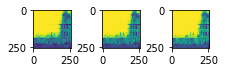

conv2d_16
(1, 256, 256, 3)


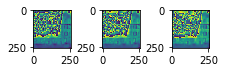

up_sampling2d_8
(1, 256, 256, 320)


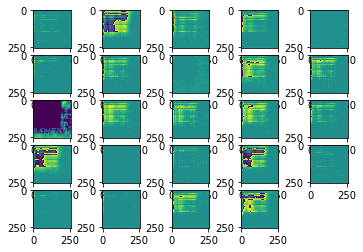

activation_7
(1, 128, 128, 320)


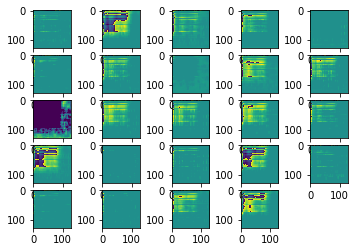

concatenate_7
(1, 128, 128, 320)


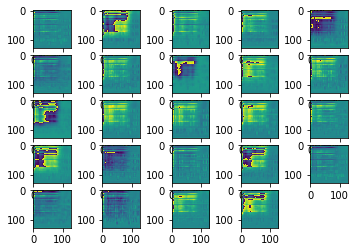

dropout_7
(1, 128, 128, 256)


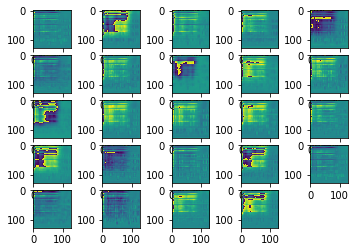

gen_de_bn_7
(1, 128, 128, 256)


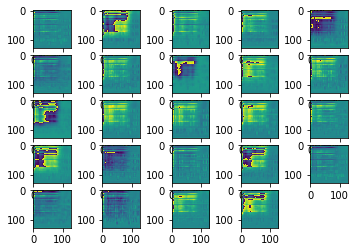

conv2d_15
(1, 128, 128, 256)


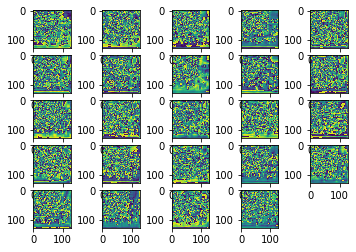

up_sampling2d_7
(1, 128, 128, 576)


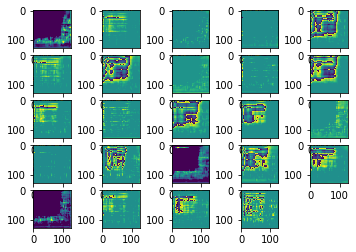

activation_6
(1, 64, 64, 576)


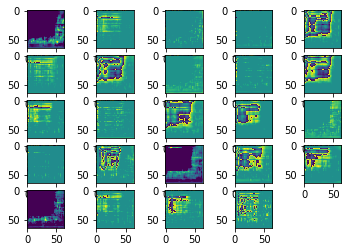

concatenate_6
(1, 64, 64, 576)


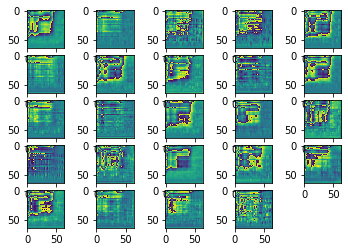

dropout_6
(1, 64, 64, 512)


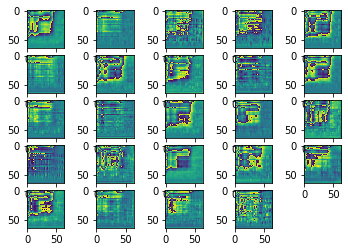

gen_de_bn_6
(1, 64, 64, 512)


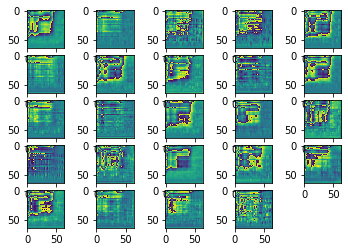

conv2d_14
(1, 64, 64, 512)


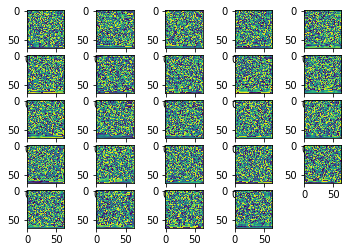

up_sampling2d_6
(1, 64, 64, 1280)


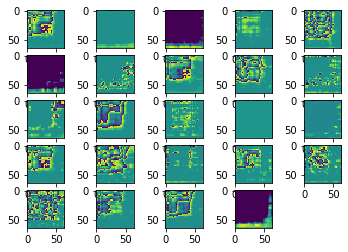

activation_5
(1, 32, 32, 1280)


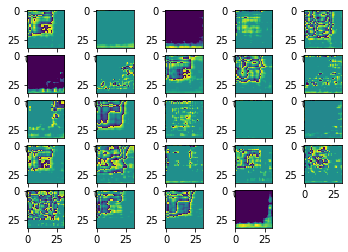

concatenate_5
(1, 32, 32, 1280)


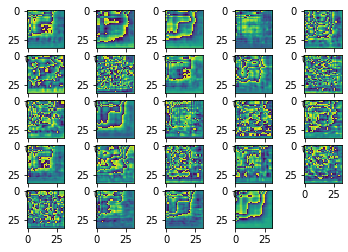

dropout_5
(1, 32, 32, 1024)


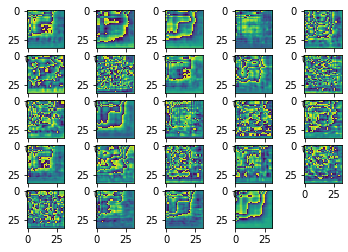

gen_de_bn_5
(1, 32, 32, 1024)


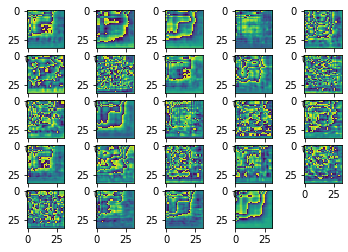

conv2d_13
(1, 32, 32, 1024)


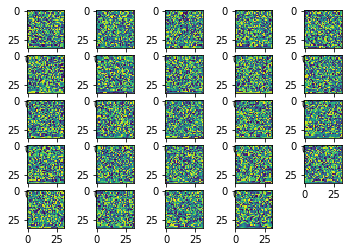

up_sampling2d_5
(1, 32, 32, 1536)


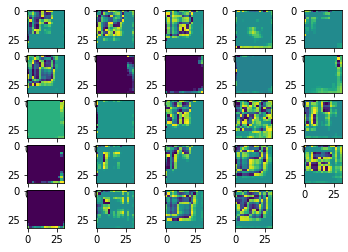

activation_4
(1, 16, 16, 1536)


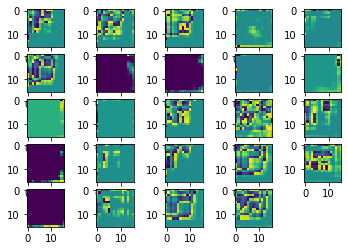

concatenate_4
(1, 16, 16, 1536)


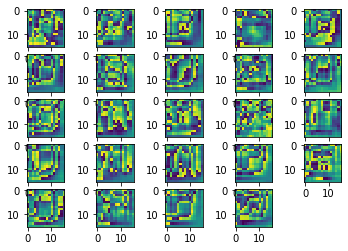

dropout_4
(1, 16, 16, 1024)


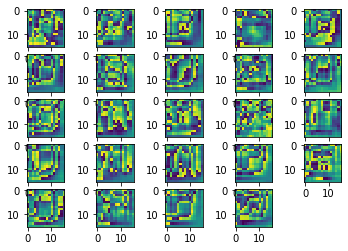

gen_de_bn_4
(1, 16, 16, 1024)


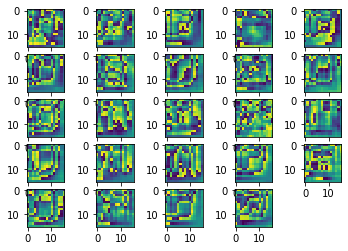

conv2d_12
(1, 16, 16, 1024)


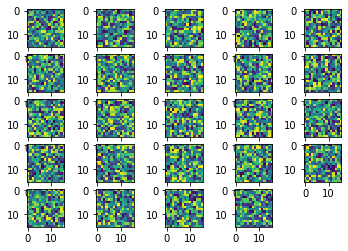

up_sampling2d_4
(1, 16, 16, 1536)


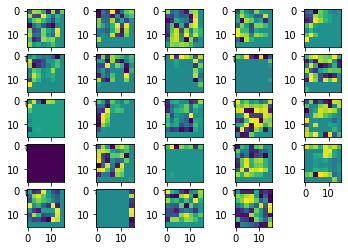

activation_3
(1, 8, 8, 1536)


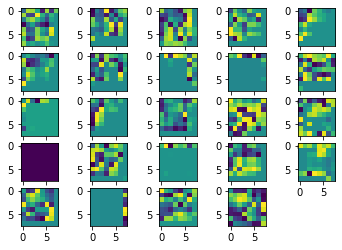

concatenate_3
(1, 8, 8, 1536)


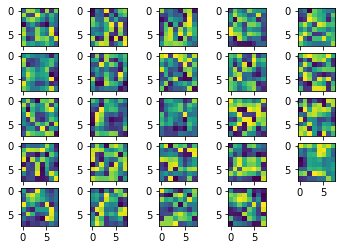

dropout_3
(1, 8, 8, 1024)


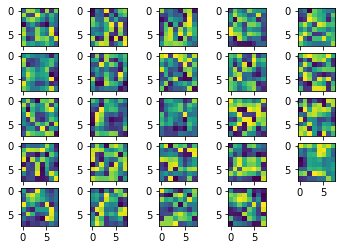

gen_de_bn_3
(1, 8, 8, 1024)


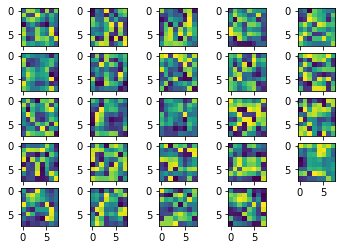

conv2d_11
(1, 8, 8, 1024)


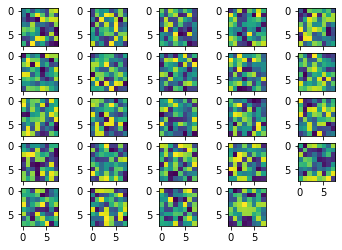

up_sampling2d_3
(1, 8, 8, 1536)


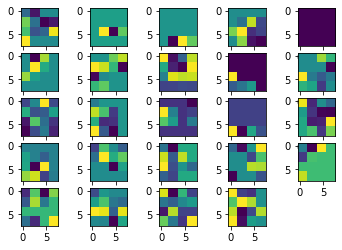

activation_2
(1, 4, 4, 1536)


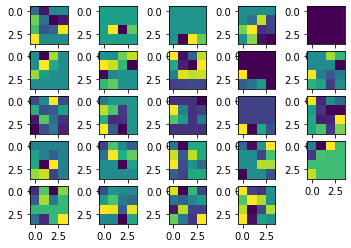

concatenate_2
(1, 4, 4, 1536)


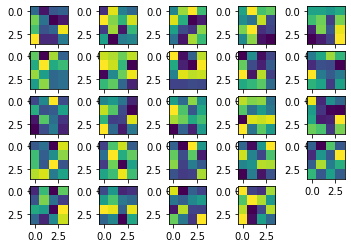

dropout_2
(1, 4, 4, 1024)


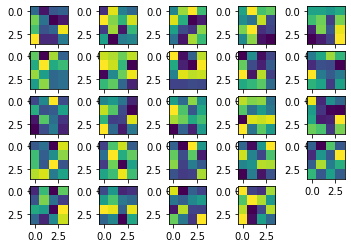

gen_de_bn_2
(1, 4, 4, 1024)


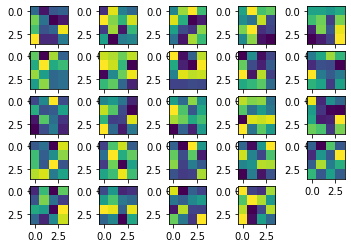

conv2d_10
(1, 4, 4, 1024)


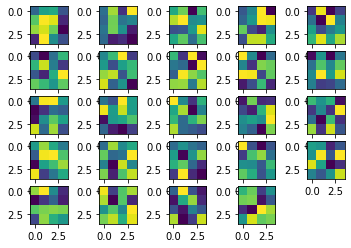

up_sampling2d_2
(1, 4, 4, 1024)


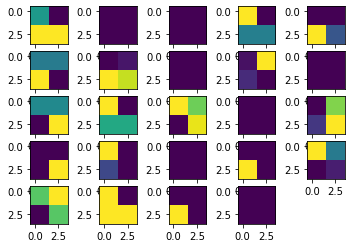

activation_1
(1, 2, 2, 1024)


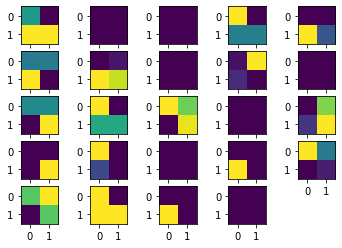

concatenate_1
(1, 2, 2, 1024)


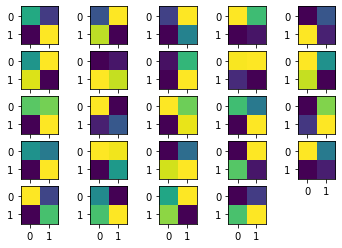

dropout_1
(1, 2, 2, 512)


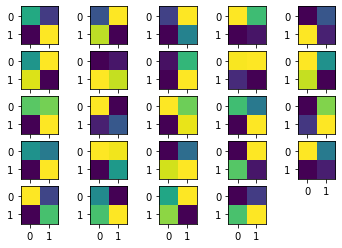

gen_de_bn_1
(1, 2, 2, 512)


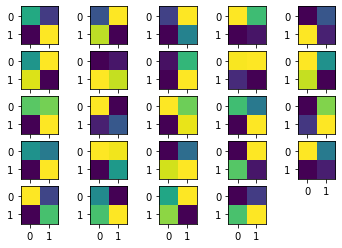

conv2d_9
(1, 2, 2, 512)


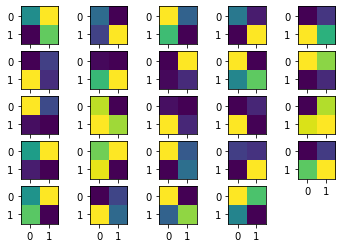

up_sampling2d_1
(1, 2, 2, 512)


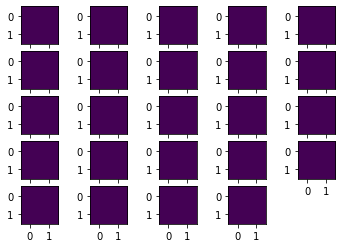

leaky_re_lu_8
(1, 1, 1, 512)


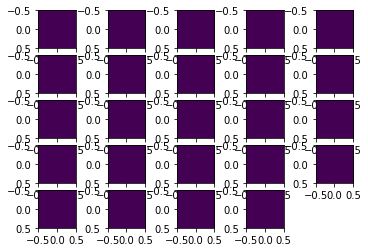

gen_en_bn_8
(1, 1, 1, 512)


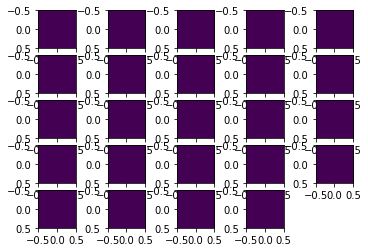

conv2d_8
(1, 1, 1, 512)


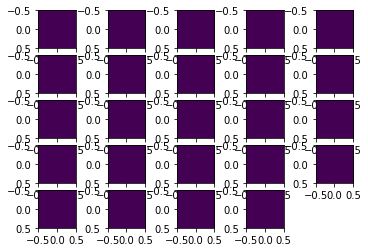

leaky_re_lu_7
(1, 2, 2, 512)


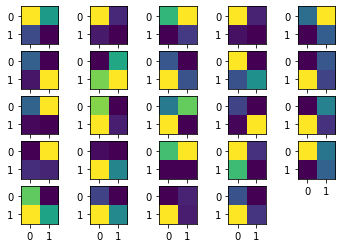

gen_en_bn_7
(1, 2, 2, 512)


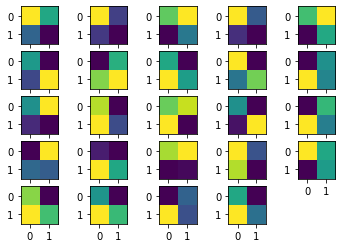

conv2d_7
(1, 2, 2, 512)


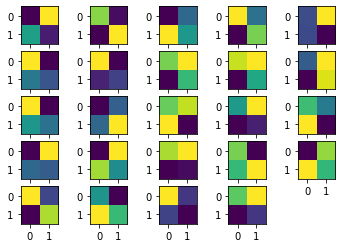

leaky_re_lu_6
(1, 4, 4, 512)


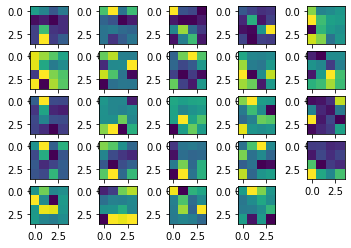

gen_en_bn_6
(1, 4, 4, 512)


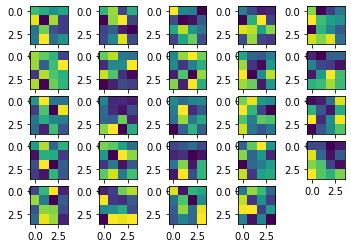

conv2d_6
(1, 4, 4, 512)


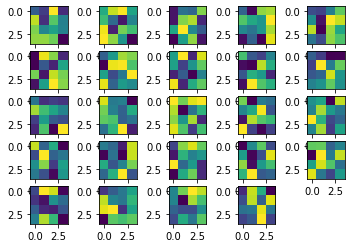

leaky_re_lu_5
(1, 8, 8, 512)


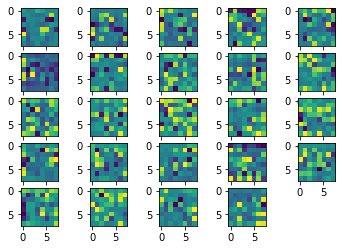

gen_en_bn_5
(1, 8, 8, 512)


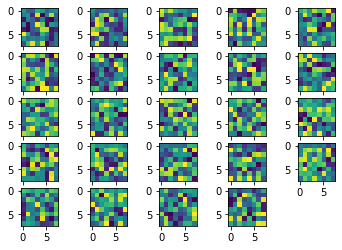

conv2d_5
(1, 8, 8, 512)


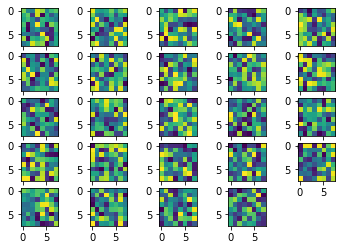

leaky_re_lu_4
(1, 16, 16, 512)


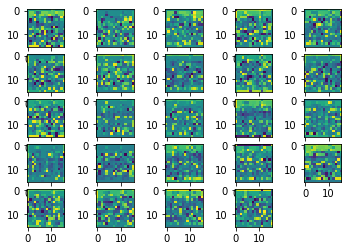

gen_en_bn_4
(1, 16, 16, 512)


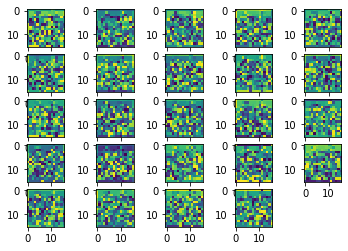

conv2d_4
(1, 16, 16, 512)


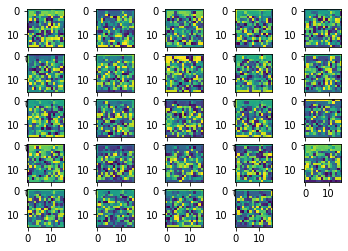

leaky_re_lu_3
(1, 32, 32, 256)


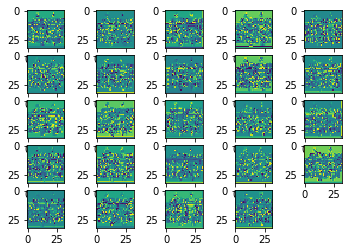

gen_en_bn_3
(1, 32, 32, 256)


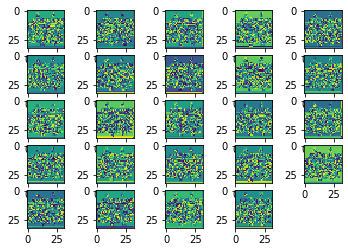

conv2d_3
(1, 32, 32, 256)


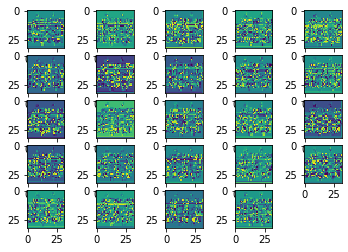

leaky_re_lu_2
(1, 64, 64, 64)


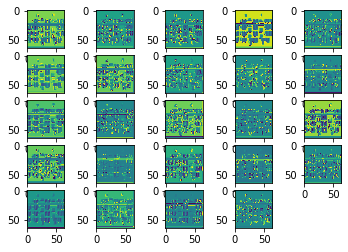

gen_en_bn_2
(1, 64, 64, 64)


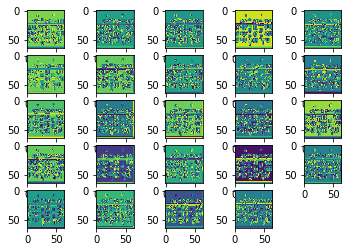

conv2d_2
(1, 64, 64, 64)


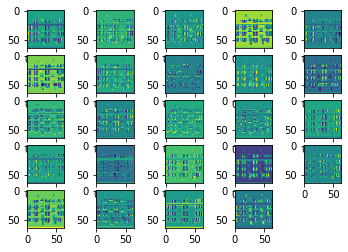

leaky_re_lu_1
(1, 128, 128, 64)


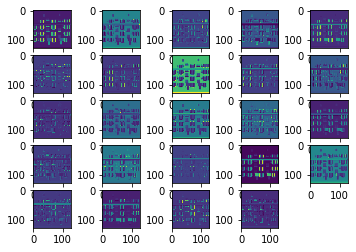

conv2d_1
(1, 128, 128, 64)


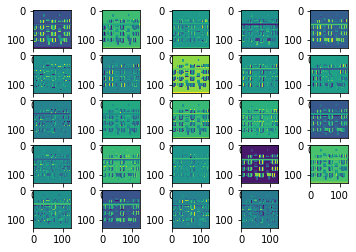

In [94]:
for i in range(-1,0-len(generator_nn.layers),-1):
    plot_weight(generator_nn,i,my_pic)

In [77]:
cv2.imwrite("result.jpg",my_pic[0]*127.5 + 127.5)

True

In [8]:
from keras.optimizers import Adam
opt_discriminator = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#这把loss设置为mse加大对异常值的敏感度
generator_nn.compile(loss='mse', optimizer=opt_discriminator)

In [9]:
import pickle as pickle
import random
import os
import numpy as np
ban_num = 2

In [10]:
def load_imdb(cur_ban):
    cur_ban = (cur_ban + 1) % ban_num
    fid = open(os.path.join("pic_db","train_{ban_index}_pic.imdb".format(ban_index=cur_ban)),'rb')
    print("read...")
    train_data = pickle.load(fid)
    #train_data = train_data[0] #只取一行做测试
    fid.close()
    print("finist...")
    random.shuffle(train_data)
    print("shuffle")
    tmp_list = np.array(train_data)
    a = tmp_list[:,0].tolist()
    b = np.copy(a)  #如果不进行copy会出现pickle的实际未释放的情况
    c = tmp_list[:,1].tolist()
    d = np.copy(c)  #如果不进行copy会出现pickle的实际未释放的情况
    #share_rate = np.copy(tmp_list[:,1])
    return b,d

In [11]:
origin_image,true_iamge = load_imdb(0)

read...
finist...
shuffle


In [13]:
for ban_i in range(1,ban_num+1):
    origin_image_tmp,true_iamge_tmp = load_imdb(ban_i)
    origin_image =np.concatenate((origin_image,origin_image_tmp),axis=0)
    true_iamge   =np.concatenate((true_iamge,true_iamge_tmp),axis=0)

read...
finist...
shuffle
read...
finist...
shuffle


In [14]:
origin_image.shape

(300, 256, 256, 3)

In [44]:
import cv2
my_pic = cv2.imread("./facades/test/1.jpg")
my_pic=  my_pic[:,256:,:]
my_pic = my_pic.astype(np.float32)
# my_pic[...,0] = (my_pic[...,0] - 187.25014568) * 0.017
# my_pic[...,1] = (my_pic[...,1] - 77.66409287) * 0.017
# my_pic[...,2] = (my_pic[...,2] - 59.52274884) * 0.017
my_pic = (my_pic - 127.5)/127.5
my_pic = my_pic.reshape(1,256,256,3)

In [18]:
origin_image.mean(0).mean(0).mean(0)

array([-0.16921851, -0.09592472, -0.04181366])

In [19]:
fake_pic = origin_image[0]
fake_pic[...,0] = (fake_pic[...,0] / 0.017 + 105.35932462)
fake_pic[...,1] = (fake_pic[...,1] / 0.017 + 112.60941372)
fake_pic[...,2] = (fake_pic[...,2] / 0.017 + 117.40256169)
cv2.imwrite("./result_tmp.jpg",fake_pic)

True

In [25]:
fake_pic = true_iamge[2]
fake_pic = fake_pic * 127.5 + 127.5
cv2.imwrite("./result_tmp.jpg",fake_pic)

True

In [22]:
!mkdir pic_tmp_bad_case

In [23]:
bad_case = [1, 2, 4, 5, 6, 11, 12, 14, 22, 24, 25, 29, 35, 38, 39, 43, 44, 45, 47, 49, 51, 52, 54, 55, 56, 59, 63, 64, 76, 79, 82, 87, 92, 96, 98, 100, 102, 103, 104, 106, 108, 109, 110, 111, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 129, 132, 133, 134, 136, 141, 142, 143, 145, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 187, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 209, 214, 216, 217, 218, 223, 224, 225, 226, 230, 233, 237, 238, 241, 244, 246, 249, 253, 258, 259, 260, 261, 262, 264, 267, 268, 269, 273, 278, 279, 280, 281, 287, 292, 294, 295]

In [45]:
nb_epoch=111
print("start trining")
for epoch in range(110, nb_epoch):
        disc_loss = 0
        for i in range(1,origin_image.shape[0]):
        #for i in bad_case:            
            disc_loss_cur =  generator_nn.train_on_batch(true_iamge[i:i+1],origin_image[i:i+1])
            disc_loss += disc_loss_cur
            output_pic =  generator_nn.predict(true_iamge[i:i+1])
            fake_pic = generator_nn.predict(my_pic)
            fake_pic = np.concatenate((fake_pic,output_pic,origin_image[i:i+1]),1)
#             fake_pic[...,0] = (fake_pic[...,0] / 0.017 + 105.35932462)
#             fake_pic[...,1] = (fake_pic[...,1] / 0.017 + 112.60941372)
#             fake_pic[...,2] = (fake_pic[...,2] / 0.017 + 117.40256169)
            fake_pic = fake_pic * 127.5 + 127.5
            cv2.imwrite("./pic_tmp_bad_case/result_{}_{}.jpg".format(epoch,i),fake_pic[0])
            print("epoch:{} {} loss:{}".format(epoch,i,disc_loss_cur))
        if epoch % 10 == 9:
            generator_nn.save_weights("b_a_model_{}.h5".format(epoch))
#         fake_pic = generator_nn.predict(my_pic)
#         fake_pic = fake_pic * 127.5 + 127.5
#         cv2.imwrite("result_{}.jpg".format(epoch),fake_pic[0])
        print("**"* 30)
        print("epoch:{} loss:{}".format(epoch,disc_loss / origin_image.shape[0]))
    #break

start trining
epoch:110 1 loss:0.07932660728693008
epoch:110 2 loss:0.05962255969643593
epoch:110 3 loss:0.0807642936706543
epoch:110 4 loss:0.059849873185157776
epoch:110 5 loss:0.07346417009830475
epoch:110 6 loss:0.07956622540950775
epoch:110 7 loss:0.03891611099243164
epoch:110 8 loss:0.06336729228496552
epoch:110 9 loss:0.053315725177526474
epoch:110 10 loss:0.052194662392139435
epoch:110 11 loss:0.051735974848270416
epoch:110 12 loss:0.04053664579987526
epoch:110 13 loss:0.03140329569578171
epoch:110 14 loss:0.06181160360574722
epoch:110 15 loss:0.03997817635536194
epoch:110 16 loss:0.03360603004693985
epoch:110 17 loss:0.047736480832099915
epoch:110 18 loss:0.048725154250860214
epoch:110 19 loss:0.04835456609725952
epoch:110 20 loss:0.03305044397711754
epoch:110 21 loss:0.033524759113788605
epoch:110 22 loss:0.060981571674346924
epoch:110 23 loss:0.04595832899212837
epoch:110 24 loss:0.07229762524366379
epoch:110 25 loss:0.05872301384806633
epoch:110 26 loss:0.039141520857810974

epoch:110 213 loss:0.037418052554130554
epoch:110 214 loss:0.049982789903879166
epoch:110 215 loss:0.03348200023174286
epoch:110 216 loss:0.05895237624645233
epoch:110 217 loss:0.0404089018702507
epoch:110 218 loss:0.039906881749629974
epoch:110 219 loss:0.03822769224643707
epoch:110 220 loss:0.039892930537462234
epoch:110 221 loss:0.03840665519237518
epoch:110 222 loss:0.03261943161487579
epoch:110 223 loss:0.051020074635744095
epoch:110 224 loss:0.05163024365901947
epoch:110 225 loss:0.056500181555747986
epoch:110 226 loss:0.04746237397193909
epoch:110 227 loss:0.0296107716858387
epoch:110 228 loss:0.03324155882000923
epoch:110 229 loss:0.044947411864995956
epoch:110 230 loss:0.07894250005483627
epoch:110 231 loss:0.048001255840063095
epoch:110 232 loss:0.028642721474170685
epoch:110 233 loss:0.08752895891666412
epoch:110 234 loss:0.04573734104633331
epoch:110 235 loss:0.046783797442913055
epoch:110 236 loss:0.03204362839460373
epoch:110 237 loss:0.05896158888936043
epoch:110 238 los

In [27]:
!mkdir pic_fuck_191

In [39]:
import cv2
my_pic = cv2.imread("./facades/test/1.jpg")
my_pic = (my_pic - 127.5)/127.5
my_pic_b=  my_pic[:,256:,:]
my_pic_a=  my_pic[:,:256,:]
# my_pic[...,0] = (my_pic[...,0] - 187.25014568) * 0.017
# my_pic[...,1] = (my_pic[...,1] - 77.66409287) * 0.017
# my_pic[...,2] = (my_pic[...,2] - 59.52274884) * 0.017

my_pic_a = my_pic_a.reshape(1,256,256,3)
my_pic_b = my_pic_b.reshape(1,256,256,3)

In [42]:
for j in range(100,200):
#for i in bad_case: 
    i = 124
    disc_loss_cur =  generator_nn.train_on_batch(my_pic_b,my_pic_a)
    disc_loss += disc_loss_cur
    output_pic =  generator_nn.predict(my_pic_b)
    fake_pic = generator_nn.predict(my_pic_b)
    fake_pic = np.concatenate((fake_pic,output_pic,my_pic_a),1)
    fake_pic = fake_pic * 127.5 + 127.5
    cv2.imwrite("./pic_fuck_191/result_{}.jpg".format(j),fake_pic[0])
    print("epoch:{} {} loss:{}".format(epoch,j,disc_loss_cur))

epoch:109 100 loss:0.013369669206440449
epoch:109 101 loss:0.013894081115722656
epoch:109 102 loss:0.013152859173715115
epoch:109 103 loss:0.013078439049422741
epoch:109 104 loss:0.01285889558494091
epoch:109 105 loss:0.013201947323977947
epoch:109 106 loss:0.013138696551322937
epoch:109 107 loss:0.012707788497209549
epoch:109 108 loss:0.012991931289434433
epoch:109 109 loss:0.013077393174171448
epoch:109 110 loss:0.01278744824230671
epoch:109 111 loss:0.012637153267860413
epoch:109 112 loss:0.013052688911557198
epoch:109 113 loss:0.012563340365886688
epoch:109 114 loss:0.013062765821814537
epoch:109 115 loss:0.012887304648756981
epoch:109 116 loss:0.01269645057618618
epoch:109 117 loss:0.012611017562448978
epoch:109 118 loss:0.014085305854678154
epoch:109 119 loss:0.0123521089553833
epoch:109 120 loss:0.012712923809885979
epoch:109 121 loss:0.0138105358928442
epoch:109 122 loss:0.01301661692559719
epoch:109 123 loss:0.012808240950107574
epoch:109 124 loss:0.012196328490972519
epoch:10

KeyboardInterrupt: 

In [37]:
for j in range(0,100):
#for i in bad_case: 
    i = 124
    disc_loss_cur =  generator_nn.train_on_batch(true_iamge[i:i+1],origin_image[i:i+1])
    disc_loss += disc_loss_cur
    output_pic =  generator_nn.predict(true_iamge[i:i+1])
    fake_pic = generator_nn.predict(my_pic)
    fake_pic = np.concatenate((fake_pic,output_pic,origin_image[i:i+1]),1)
    fake_pic = fake_pic * 127.5 + 127.5
    cv2.imwrite("./pic_fuck_191/result_{}.jpg".format(j),fake_pic[0])
    print("epoch:{} {} loss:{}".format(epoch,j,disc_loss_cur))

epoch:109 0 loss:0.020141813904047012
epoch:109 1 loss:0.017354333773255348
epoch:109 2 loss:0.017893444746732712
epoch:109 3 loss:0.017672501504421234
epoch:109 4 loss:0.01962876319885254
epoch:109 5 loss:0.017701173201203346
epoch:109 6 loss:0.017390219494700432
epoch:109 7 loss:0.017338629812002182
epoch:109 8 loss:0.017114149406552315
epoch:109 9 loss:0.017157945781946182
epoch:109 10 loss:0.017530161887407303
epoch:109 11 loss:0.016898954287171364
epoch:109 12 loss:0.01773896999657154
epoch:109 13 loss:0.018208811059594154
epoch:109 14 loss:0.01665831357240677
epoch:109 15 loss:0.016609419137239456
epoch:109 16 loss:0.016914743930101395
epoch:109 17 loss:0.01682736724615097
epoch:109 18 loss:0.016156082972884178
epoch:109 19 loss:0.01741056889295578
epoch:109 20 loss:0.019460253417491913
epoch:109 21 loss:0.016516778618097305
epoch:109 22 loss:0.017031516879796982
epoch:109 23 loss:0.01703770086169243
epoch:109 24 loss:0.016445444896817207
epoch:109 25 loss:0.016457222402095795
ep

In [15]:
import cv2
my_pic = cv2.imread("./facades/test/5.jpg")
my_pic=  my_pic[:,256:,:]
my_pic = my_pic.reshape(1,256,256,3)
my_pic = (my_pic - 127.5) / 127.5
fake_pic = generator_nn.predict(my_pic)
fake_pic = fake_pic * 127.5 + 127.5
cv2.imwrite("result.jpg".format(epoch),fake_pic[0])

True

In [46]:
import cv2
my_pic = cv2.imread("./facades/test/49.jpg")

In [48]:
HSV = cv2.cvtColor(my_pic, cv2.COLOR_BGR2HSV)

In [52]:
HSV[:,:256,:]

array([[[105,  50, 221],
        [105,  50, 221],
        [105,  51, 223],
        ...,
        [104,  65, 220],
        [104,  65, 220],
        [113,  91, 255]],

       [[105,  50, 221],
        [105,  50, 221],
        [105,  51, 223],
        ...,
        [104,  65, 220],
        [104,  65, 220],
        [113,  91, 255]],

       [[105,  51, 223],
        [105,  51, 223],
        [105,  51, 223],
        ...,
        [104,  65, 220],
        [104,  65, 220],
        [113,  91, 255]],

       ...,

       [[  2, 100, 138],
        [  2, 108, 128],
        [  2, 103, 131],
        ...,
        [ 34,  13, 163],
        [ 34,  12, 164],
        [119,  63, 205]],

       [[  3,  89, 126],
        [  3,  97, 116],
        [  3,  93, 121],
        ...,
        [ 36,  10, 131],
        [ 36,   9, 135],
        [119,  77, 182]],

       [[  5,  81, 126],
        [  5,  89, 115],
        [  4,  80, 121],
        ...,
        [  0,   0,   0],
        [ 30, 255,   1],
        [120, 255,  48]]